# Run Machine Learning

We now run machine learning on the clean data file created in the "TransformData" script. It contains clean monthly stock and factor data between January 2004 and December 2023.

We begin by importing packages, and loading in our data.

In [1]:
#Load packages
suppressPackageStartupMessages({
    if(!require(tidyverse)){install.packages("tidyverse")}
    if(!require(tidyquant)){install.packages("tidyquant")}
    if(!require(lubridate)){install.packages("lubridate")}
    if(!require(glmnet)){install.packages("glmnet")}
    if(!require(rpart)){install.packages("rpart")}
    if(!require(randomForest)){install.packages("randomForest")}
    if(!require(xgboost)){install.packages("xgboost")}
    if(!require(keras3)){install.packages("keras3")}
    if(!require(quadprog)){install.packages("quadprog")}
    
    library(tidyverse)
    library(tidyquant)
    library(lubridate)
    library(glmnet)
    library(rpart)
    library(randomForest)
    library(xgboost)
    library(keras3)
    library(quadprog)
})

In [2]:
#Import data
clean_data <- read_csv("Data/Generated/clean_data.csv", show_col_types = FALSE) %>%
    arrange(PERMNO, DATE)

head(clean_data)

DATE,PERMNO,PERMCO,TIC,PRC,RET,SHROUT,CEQ,VOL,XRM,⋯,XRET,FRET,MCAP,BMKT,RET11,XRET11,RV,WML_star,N,GRJMOM
<date>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2004-01-31,10026,7976,JJSF,42.10,0.114936,8801,182.564,0.09347483,0.0215,⋯,0.114236,0.122565,0.2973503,0.5750736,0.03309673,0.4818449,0.4317959,0.034519963,0.9,0.3954858
2004-02-29,10026,7976,JJSF,47.26,0.122565,8801,182.564,0.09796190,0.0140,⋯,0.121965,-0.044012,0.3209028,0.4936212,0.03532145,0.4563297,0.3444553,-0.013857615,0.9,0.3316977
2004-03-31,10026,7976,JJSF,45.18,-0.044012,8906,182.564,0.10015411,-0.0132,⋯,-0.044912,-0.165339,0.3107843,0.5392157,0.04209582,0.5401961,0.3911765,0.001996524,0.9,0.4039216
2004-04-30,10026,7976,JJSF,37.71,-0.165339,8911,182.564,0.10577529,-0.0183,⋯,-0.166139,0.048263,0.2843137,0.6313725,0.03380709,0.5176471,0.3294118,-0.064352988,0.9,0.3470588
2004-05-31,10026,7976,JJSF,39.53,0.048263,8911,182.564,0.10950843,0.0117,⋯,0.047663,0.032886,0.2990196,0.6196078,0.01954936,0.4107843,0.2705882,0.018351628,0.9,0.2990196
2004-06-30,10026,7976,JJSF,40.83,0.032886,8969,182.564,0.10883277,0.0186,⋯,0.032086,-0.100416,0.2956778,0.6139489,0.02416791,0.5186640,0.3290766,0.026936144,0.9,0.3713163


We split our data in half forming a training sample from January 2004 to December 2013, and a testing sample from January 2014 to December 2023.

In [3]:
#Setup samples 
separation_date <- as.Date("2014-1-1")                #Middle of period
training_sample <- filter(clean_data,                 #Training data
                          DATE < separation_date)
testing_sample <- filter(clean_data,                  #Testing data
                         DATE >= separation_date)

training_dates <- select(training_sample, DATE) %>%   #Dates for training
    unique()
testing_dates <- select(testing_sample, DATE) %>%     #Dates for testing
    unique()

#Set benchmark predictors
benchmark_feat <- c("XRM", "MCAP", "BMKT", "RET11")

# Setup Machine Learning 
Now, we create a series of functions that can train our 5 machine learning model; elastic net, decision tree, random forest, boosted decision tree, and neural network. This training is done for a set of training data, and a list of stock features. In most cases, parameter values are hard coded to reduce runtimes.

## Elastic Net
First, we have the elastic net. Our alpha parameter is hard coded as 0.5, but cross-validation is used to find the best lambda value.

In [4]:
#Train elastic net
Train_ENet <- function (train_data, features) {
    alp = 0.5 # Hard coded alpha value
    
    y_penalized_train <- train_data$FRET            
    x_penalized_train <- train_data %>%                 
        select(all_of(features)) %>% as.matrix()
    
    #Use cross validation to find best lambda parameter
    cv_pen <- cv.glmnet(x_penalized_train, y_penalized_train,
                           alpha = alp)
    best_lambda <- cv_pen$lambda.min
    
    #Use best lambda to get our fit model
    fit_pen_pred <- glmnet(x_penalized_train, y_penalized_train,
                           alpha = alp, lambda = best_lambda) 
    
    return (fit_pen_pred)
}

In [5]:
#Test the function
net <- Train_ENet(training_sample, benchmark_feat)  #Train

x_penalized_train <- training_sample %>%            #Format data
    select(all_of(benchmark_feat)) %>% as.matrix()  

#Show training mean absolute error
err_elnet <- predict(net, x_penalized_train) - training_sample$FRET
mean(abs(err_elnet))

[1] 0.07664949

## Decision Tree
Next we setup a decision tree, again with a hard-coded precision (number of leaves) and maximum depth.

In [6]:
#Train Decision Tree
Train_Dec_Tree <- function (train_data, features) {
    precision <- 0.0001 #Hard coded precision
    depth <- 5          #Hard coded depth
    
    formula <- paste("FRET ~", paste(features, collapse = " + ")) # Defines the model 
    formula <- as.formula(formula)                                # Forcing formula object
    
    fit_tree <- rpart(formula, data = train_data,                 #Fit model
                 cp = precision, maxdepth = depth)
    
    return (fit_tree)
}

In [7]:
#Test the function
tree <- Train_Dec_Tree(training_sample, benchmark_feat) #Train

#Show training mean absolute error
err_tree_train <- predict(tree, training_sample) - training_sample$FRET
mean(abs(err_tree_train))

[1] 0.07267533

## Random Forest
Next, we setup for random forests. The hyperparameters of tree sample size, terminal node cluster size, number of random trees and number of predictive variables per tree are hard coded.

In [8]:
#Train Random Forest
Train_Rand_Forest <- function(train_data, features) {
    s_size <- 10000 #Size of (random) sample for each tree
    n_size <- 250   #Minimum size of terminal cluster
    n_trees <- 40   #Number of random trees
    n_var <- 3      #Number of predictive variables for each tree
    
    formula <- paste("FRET ~", paste(features, collapse = " + ")) # Defines the model 
    formula <- as.formula(formula)                                # Forcing formula object
    fit_RF <- randomForest(formula, data = training_sample, sampsize = s_size,          
                     replace = FALSE, nodesize = n_size, ntree = n_trees, mtry = n_var)   
    
    return (fit_RF)
}

In [9]:
#Test the function
forest <- Train_Rand_Forest(training_sample, benchmark_feat) #Train

#Show training mean absolute error
err_forest_train <- predict(forest, training_sample) - training_sample$FRET
mean(abs(err_forest_train))

[1] 0.06902822

## Boosted Decision Tree
The boosted decision tree first requires the data to be in the XGB format. Note that we only use the training data with extreme values (in the first or fifth quantiles) to reduce training time and focus on the most impactful data points.

In [10]:
#Format data to XGB format
XGB_Matrix <- function(train_data, features) {
    train_features_xgb <- train_data %>%           #Independent variable
        filter(FRET < quantile(FRET, 0.2) |        #Select extreme values
                   FRET > quantile(FRET, 0.8)) %>%            
        select(all_of(features)) %>% as.matrix()
    
    train_label_xgb <- train_data %>%              #Dependent variable
        filter(FRET < quantile(FRET, 0.2) |        #Select extreme values
                   FRET > quantile(FRET, 0.8)) %>%
        select(all_of(c("FRET"))) %>% as.matrix()                     
    
    train_matrix_xgb <- xgb.DMatrix(data = train_features_xgb, #XGB format
                                    label = train_label_xgb)    
    
    return (train_matrix_xgb)
}

Again, all hyperparameters are hard-coded included the penalisation of leaves, number of trees used, and maximum tree depth.

In [11]:
#Train boosted decision tree
Train_Boost_Tree <- function(train_data, features) {
    penalty <- 1  #Penalisation of of leaves
    n_trees <- 40   #Number of trees used
    max_depth <- 5  #Maximum tree depth
    
    train_matrix_xgb <- XGB_Matrix(train_data, features) #Format
    
    fit_xgb <- xgb.train(data = train_matrix_xgb, gamma = penalty, #Fit                     
                  nrounds = n_trees, max_depth = max_depth, verbose = 0)
    
    return (fit_xgb)
}

In [12]:
#Test the function
boost_tree <- Train_Boost_Tree(training_sample, benchmark_feat) #Train

xgb_train <- training_sample %>%   #Format data
    select(all_of(benchmark_feat)) %>% 
    as.matrix() 

#Show training mean absolute error
err_XGB_train <- predict(boost_tree, xgb_train) - training_sample$FRET
mean(abs(err_XGB_train))

[1] 0.07142203

## Neural Net
Finally, we have the neural network. A simple model is used that has three layers of 64, 16, and 4 nodes using the sigmoid activation function.

In [13]:
#Train neural net
Train_Neural_Net <- function(train_data, features) {
    NN_train_features <- train_data %>%           #Training features
        select(all_of(features)) %>% as.matrix()
    NN_train_labels <- train_data$FRET            #Training labels

    #Define network structure
    model <- keras_model_sequential()
    model %>%
        layer_dense(units = 64, activation = 'sigmoid', input_shape = ncol(NN_train_features)) %>%
        layer_dense(units = 16, activation = 'sigmoid', input_shape = ncol(NN_train_features)) %>%
        layer_dense(units = 4, activation = 'sigmoid') %>%
        layer_dense(units = 1) # No activation means linear activation

    #Compile the model
    model %>% compile(loss = 'mean_squared_error', optimizer = optimizer_rmsprop())

    #Fit the model on training data
    model %>% fit(NN_train_features, NN_train_labels, epochs = 10, batch_size = 512)
    
    return (model)
}

In [14]:
#Test the function
NN_train_features <- training_sample %>%                   #Format
    select(all_of(benchmark_feat)) %>% as.matrix()

model <- Train_Neural_Net(training_sample, benchmark_feat) #Train

#Show training mean absolute error
rr_NN_train <- predict(model, NN_train_features) - training_sample$FRET
mean(abs(rr_NN_train))

[1] 0.07739827

# Setup Model Training
Now, we create a function that using the selected set of features, trains all of our 5 models seperately on the given training data. It returns the predictions for each of these models on the given test data.

In [15]:
#Train ensemble models
Train_Ensemble_Models <- function(train_data, test_data, features) {
    #Train elastic net
    net <- Train_ENet(train_data, features)
    x_penalized_test <- test_data %>%                                    
       select(one_of(features)) %>% as.matrix()  
    pen_pred <- predict(net, x_penalized_test)

    #Train decision tree
    tree <- Train_Dec_Tree(train_data, features)
    tree_pred <- predict(tree, test_data)

    #Train random forest
    forest <- Train_Rand_Forest(train_data, features)
    RF_pred <- predict(forest, test_data)

    #Train boosted tree
    boost_tree <- Train_Boost_Tree(train_data, features)
    xgb_test <- test_data %>%                         
        select(all_of(features)) %>% 
        as.matrix() 
    XGB_pred <- predict(boost_tree, xgb_test) 

    #Train Neural Net
    model <- Train_Neural_Net(train_data, features)
    NN_test <- test_data %>% 
        select(all_of(features)) %>% as.matrix()
    NN_pred <- predict(model, NN_test)

    #Store predictions and return
    predictions <- cbind(pen_pred, tree_pred, RF_pred, XGB_pred, NN_pred)
    colnames(predictions) <- c("Pen_reg", "Tree", "RF", "XGB", "NN")
    return (predictions)
}

In [16]:
#Test ensemble training function - show model predictions
model_preds <- Train_Ensemble_Models(training_sample, training_sample, benchmark_feat)
head(model_preds)

,Pen_reg,Tree,RF,XGB,NN
1,0.017215035,0.013226401,0.016347659,-0.01580454,0.006197676
2,0.014504626,0.035395046,0.008809728,0.06131855,0.005897887
3,0.007069302,0.006723391,-0.023998467,-0.03154884,0.006008334
4,0.006935380,0.006723391,-0.003666540,-0.00537501,0.006314121
5,0.015728066,0.035395046,0.037690531,0.06131855,0.006317325
6,0.017246463,-0.024503385,-0.037683829,-0.07820705,0.006316923


# Calculate Ensemble Weights

Once we train our models seperately, they can be combined to form an ensemble portfolio.

## Compute Model Errors

First, examine the error of the individual model predictions.

In [17]:
#Show individual model error
ensemble_errors <- model_preds - training_sample$FRET
head(ensemble_errors)

,Pen_reg,Tree,RF,XGB,NN
1,-0.10534996,-0.109338599,-0.106217341,-0.13836954,-0.11636732
2,0.05851663,0.079407046,0.052821728,0.10533055,0.04990989
3,0.17240830,0.172062391,0.141340533,0.13379016,0.17134733
4,-0.04132762,-0.041539609,-0.051929540,-0.05363801,-0.04194888
5,-0.01715793,0.002509046,0.004804531,0.02843255,-0.02656868
6,0.11766246,0.075912615,0.062732171,0.02220895,0.10673292


These errors can be used to check model correlation which is key for an ensemble approach.

In [18]:
#Show correlation
cor(ensemble_errors)

,Pen_reg,Tree,RF,XGB,NN
Pen_reg,1.0000000,0.9331429,0.9442472,0.8364301,0.9947364
Tree,0.9331429,1.0000000,0.9444912,0.9153203,0.9279569
RF,0.9442472,0.9444912,1.0000000,0.9319004,0.9415794
XGB,0.8364301,0.9153203,0.9319004,1.0000000,0.8275844
NN,0.9947364,0.9279569,0.9415794,0.8275844,1.0000000


We can see that for our benchmark features, at least on the training data, most of our models are heavily correlated. This means that the benefit from the ensemble approach is reduced. The neural network and boosted decision tree are by far the least correlated, so they will add valuable information to the ensemble.

Next, view individual model performance ()mean absolute error .

In [19]:
apply(abs(ensemble_errors), 2, mean);

Pen_reg       Tree         RF        XGB         NN 
0.07664949 0.07267533 0.06913988 0.07142203 0.07648341

We can see that the random forest performs the best on the training data, while the neural network and penalized regression underform.

## Compute Weights

Now, we can create a function that uses these errors to find the optimal weighting of these models that minimizes sample error. We want to enforce positive weights within our ensemble algorithm since adding leverage at the expense of poorly performing models worsens overfitting. So, we use the quadprog package to apply constraints to our optimization problem, ensuring that our weights sum to 1, and are positive.

In [20]:
#Use prediction errors to create optimal weights
Compute_Ensemble_Weights <- function(ensemble_errors) {
    nb_mods <- ncol(ensemble_errors)
    Sigma <- t(ensemble_errors) %*% ensemble_errors #Unscaled covariance matrix
    nb_mods <- nrow(Sigma)                  #Number of models
    w_const <- solve.QP(Dmat = Sigma,       #D matrix =  Sigma
                  dvec = rep(0, nb_mods),   #Zero vector
                  Amat = rbind(rep(1, nb_mods), diag(nb_mods)) %>% t(), #A matrix for constraints
                  bvec = c(1,rep(0, nb_mods)),                          #b vector for constraints
                  meq = 1                   #1 line of equality constraints, others = inequalities
                  )
    return (w_const$solution)          # Solution
}

In [21]:
#Test ensemble weighting function
ensemble_weights <- Compute_Ensemble_Weights(ensemble_errors)
round(ensemble_weights, 4)

[1] 0.0000 0.0951 0.1839 0.6881 0.0328

Our optimal solution for the benchmark features does not use the penalized regression, or the neural network. This is not surprising since they performed poorly over the training period.

## Combined Ensemble Returns

Once we have ensemble weightings, we can use our ensemble model to predict returns, and evaluate its performance. To accomplish this, we create a function to combine our individual model predictions based on the given weights.

In [22]:
#Compute ensemble predictions based on weighting
Compute_Ensemble_Pred <- function(preds, wts) {
    ens_preds <- as_tibble(preds) %>%
        mutate(preds = Pen_reg * wts[1] + Tree * wts[2] + #Compute prediction
               RF * wts[3] + XGB * wts[4] + NN * wts[5]) %>%
        select(preds)                                     #Return just prediction
    
    return (ens_preds$preds)
}

In [23]:
#Test ensemble prediction function on training data
ensemble_preds <- Compute_Ensemble_Pred(model_preds, ensemble_weights)

#Compute mean absolute error of predictions
opt_ens_error <- ensemble_preds - training_sample$FRET
mean(abs(opt_ens_error))

[1] 0.06948192

We can see that the ensemble approach has similar performance to the best model (random forest) over the training data. It should generalize better to testing data, with the difference in models reducing overfitting.

# Creating Ensemble Portfolio

We now return to the investing world, and create a portfolio based on our predictions. We split stocks into quantiles based on their predicted returns and create the 0-cost portfolio by longing the highest decile and shorting the lowest decile. We will simply apply an equal-weighted approach within stocks for simplicity, though the model performance could be improved with further optimization.

In [24]:
Compute_Ensemble_Returns <- function (test_data, ens_pred) {
    #Return to stock world with both our predicted and actual returns
    stock_data <- test_data %>%
        select(all_of(c("DATE", "PERMNO", "FRET"))) %>%
        mutate(PRED = ens_pred)         #Reformat predictions

    #Compute realized returns of our portfolio
    ensemble_returns <- stock_data %>%
        group_by(DATE) %>%
        mutate(QUANT = ntile(PRED, 10)) %>%     #Compute predicted return deciles
        summarise(LONGRET = mean(if_else(QUANT == 10, FRET, NA), #Long leg returns
                                 na.rm = TRUE),
                  SHORTRET = mean(if_else(QUANT == 1, FRET, NA), #Short leg returns
                                  na.rm = TRUE)) %>%
        mutate(RET = LONGRET - SHORTRET) %>%    #Portfolio returns
        select(all_of(c("DATE", "RET"))) %>%
        ungroup()    
    
    return (ensemble_returns)
}

In [25]:
ens_ret <- Compute_Ensemble_Returns(training_sample, ensemble_preds)
head(ens_ret)

DATE,RET
<date>,<dbl>
2004-01-31,0.015224694
2004-02-29,0.024321452
2004-03-31,0.043530598
2004-04-30,0.003686735
2004-05-31,0.054851412
2004-06-30,0.035377873


We now have the returns of the stock portfolio for each date, and can use this for our analysis.

# Putting It All Together

Now, to be able to test our different portfolio combinations, we create a wrapper function that does all of the above steps. Given our input data, test data, and a list of features, we do the following:
1. Train the 5 models individually on the training data.
2. Compute the optimal ensemble algorithm weightings.
3. Predict future returns on our test data for individual models.
4. Create our ensemble stock portfolios for both the optimal and equal weightings.
5. Return the performance (returns) of these two portfolios for our test data.

In [26]:
Ensemble_Performance <- function(train_data, test_data, feat) {
    #Train Individual Models
    model_train_preds <- Train_Ensemble_Models(train_data, train_data, feat)
    ens_train_errors <- model_train_preds - train_data$FRET

    #Compute Ensemble Weights
    ens_opt_wts <- Compute_Ensemble_Weights(ens_train_errors) #Minimum variance weighting
    ens_eq_wts <- rep(0.2, 5)                                 #Equal weighting

    #Predict returns on test data
    test_preds <- Train_Ensemble_Models(train_data, test_data, feat)

    #Create stock portfolios from ensemble predictions
    ens_opt_preds <- Compute_Ensemble_Pred(test_preds, ens_opt_wts)
    ens_opt_ret <- Compute_Ensemble_Returns(test_data, ens_opt_preds) %>%
        rename(OPT_RET = RET)

    ens_eq_preds <- Compute_Ensemble_Pred(test_preds, ens_eq_wts)
    ens_eq_ret <- Compute_Ensemble_Returns(test_data, ens_eq_preds) %>%
        rename(EQ_RET = RET)

    #Return results for both weighting methods
    return (left_join(ens_opt_ret, ens_eq_ret, by = c("DATE")))
}

## Summarizing Results

Once we do the entire training and prediction process, we now just need to summarize the results.

First, we define a function to print several basic summary statistics given the performance and name of a model.

In [27]:
#Pring summary statistics
Basic_Summary_Stat <- function(values, name) {
    mean <- mean(values) * 12
    std <- sd(values) * sqrt(12)
    sharpe <- mean / std
    kurt <- kurtosis(values)
    skew <- skewness(values)
    
    mean_text <- as.character(round(mean, 4))
    std_text <- as.character(round(std, 4))
    sharpe_text <- as.character(round(sharpe, 4))
    kurt_text <- as.character(round(kurt, 4))
    skew_text <- as.character(round(skew, 4))

    text <- paste("For ",name," the average annual return is ", mean_text, 
                  ", the standard deviation is ", std_text,
                  " and the Sharpe Ratio is ", sharpe_text,". The skew is ",
                 skew_text," and the kurtosis is ",kurt_text, sep = "")
    print(text)
}

This function produces a plot over time of the returns of all of the models provided in the data frame. The plot title needs to be provided.

In [28]:
#Plot returns of models
Plot_Returns <- function(data, name) {
    data %>%
    pivot_longer(cols = -DATE, names_to="Portfolio", values_to="returns") %>%
    ggplot(aes(x = DATE, y = returns)) + 
    ggtitle(paste("Plot of Returns Over Time for", name)) +
    geom_line(aes(linetype = Portfolio, color = Portfolio)) + 
    xlab("Time") + ylab("Portfolio Returns") +
    theme(plot.title = element_text(hjust = 0.5))
}

# Testing Portfolios

We finally have all of our functions created, so we can now use them to test a variety of different portfolio strategies.

## Original WML Portfolio (No Machine Learning)

First, we look at the base WML portfolio as defined by Fama-French, without applying any machine learning.

In [29]:
#Format portfolio
WML_perf <- testing_sample %>%
    select(all_of(c("DATE", "WML"))) %>%
    setNames(c("DATE", "RET")) %>%
    unique()

In [30]:
#Print summary statistics
Basic_Summary_Stat(WML_perf$RET, "Base WML")

[1] "For Base WML the average annual return is 0.009, the standard deviation is 0.1369 and the Sharpe Ratio is 0.0657. The skew is -0.7333 and the kurtosis is 2.0409"


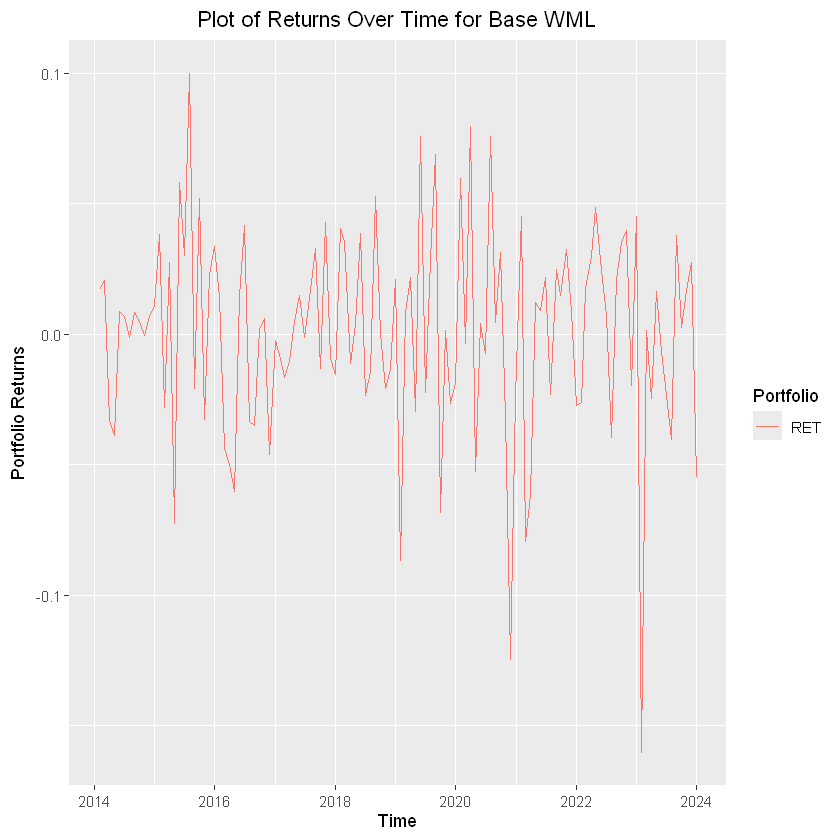

In [31]:
#Plot returns
Plot_Returns(WML_perf, "Base WML")

## Benchmark Portfolio

Next, we have our benchmark portfolio which uses the momentum factor without any risk adjustment.

In [32]:
#Test portfolio
bench_feat <- c("XRM", "MCAP", "BMKT", "RET11")
test_bench_perf <- Ensemble_Performance(training_sample, testing_sample, bench_feat)

In [33]:
#Print summary statistics
Basic_Summary_Stat(test_bench_perf$OPT_RET, "Benchmark Optimal Weight")
Basic_Summary_Stat(test_bench_perf$EQ_RET, "Benchmark Equal Weight")

[1] "For Benchmark Optimal Weight the average annual return is 0.0884, the standard deviation is 0.1509 and the Sharpe Ratio is 0.5859. The skew is 1.5259 and the kurtosis is 7.2322"
[1] "For Benchmark Equal Weight the average annual return is 0.1086, the standard deviation is 0.1872 and the Sharpe Ratio is 0.5802. The skew is 1.3261 and the kurtosis is 4.5167"


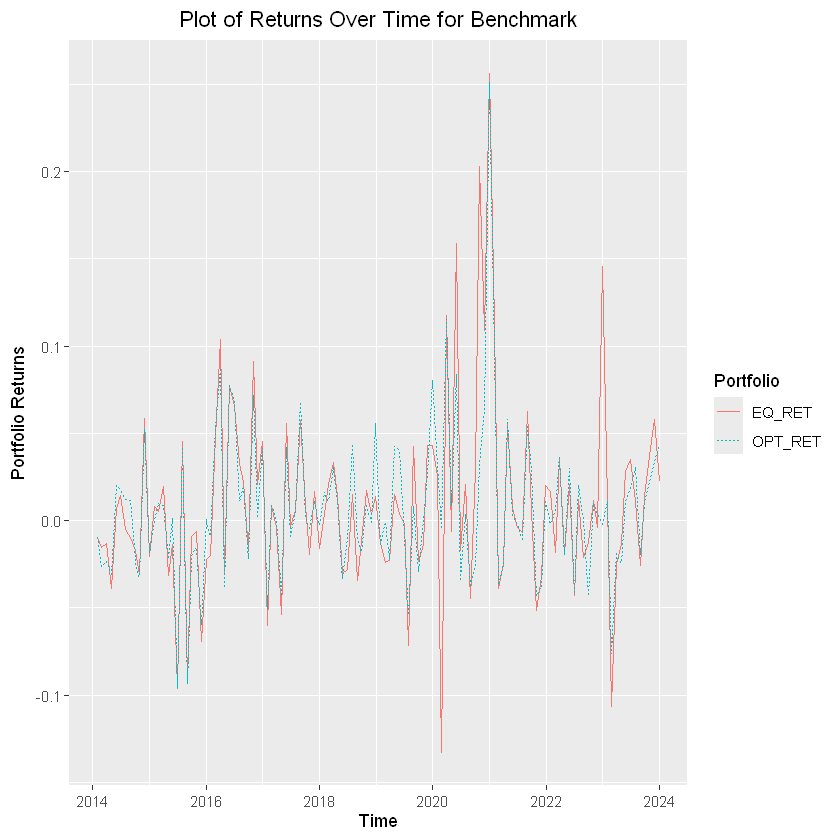

In [34]:
#Plot returns
Plot_Returns(test_bench_perf, "Benchmark")

## Risk-Variance Ratio

Next, we test the risk-variance factor.

In [35]:
#Test portfolio
rv_feat <- c("XRM", "MCAP", "BMKT", "RV")
test_rv_perf <- Ensemble_Performance(training_sample, testing_sample, rv_feat)

In [36]:
#Print summary statistics
Basic_Summary_Stat(test_rv_perf$OPT_RET, "RV Optimal Weight")
Basic_Summary_Stat(test_rv_perf$EQ_RET, "RV Equal Weight")

[1] "For RV Optimal Weight the average annual return is 0.1156, the standard deviation is 0.14 and the Sharpe Ratio is 0.8251. The skew is 1.2818 and the kurtosis is 4.174"
[1] "For RV Equal Weight the average annual return is 0.1294, the standard deviation is 0.1586 and the Sharpe Ratio is 0.8161. The skew is 1.0374 and the kurtosis is 1.9137"


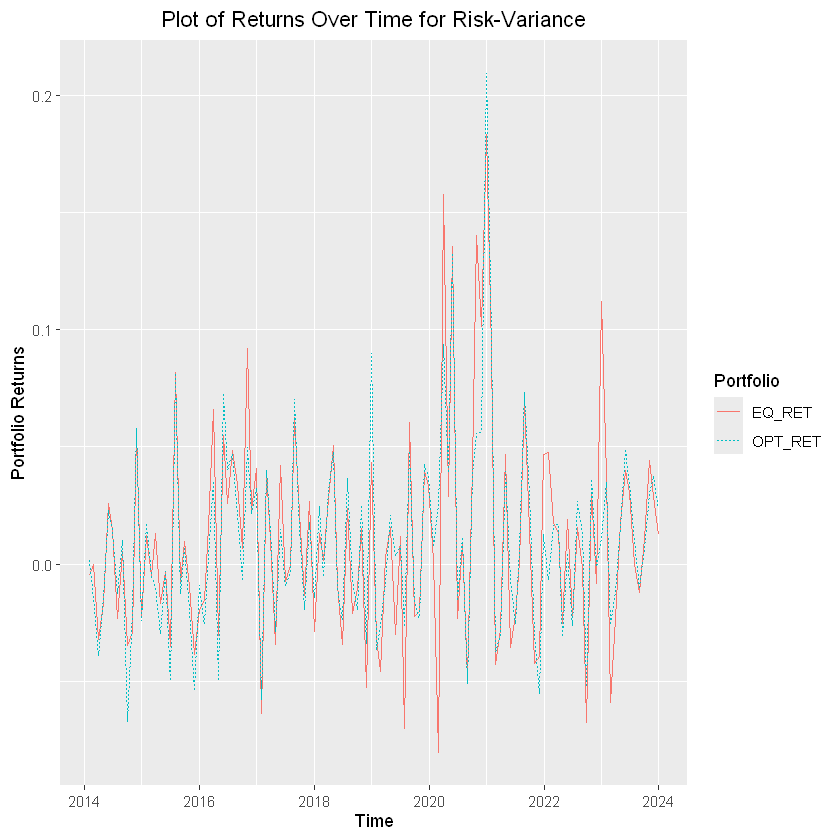

In [37]:
#Plot returns
Plot_Returns(test_rv_perf, "Risk-Variance")

## GRJMOM
Now, we use the GRJMOM factor.

In [38]:
#Test portfolio
grjmom_feat <- c("XRM", "MCAP", "BMKT", "GRJMOM")
test_grj_perf <- Ensemble_Performance(training_sample, testing_sample, grjmom_feat)

In [39]:
#Print summary statistics
Basic_Summary_Stat(test_grj_perf$OPT_RET, "GRJMOM Optimal Weight")
Basic_Summary_Stat(test_grj_perf$EQ_RET, "GRJMOM Equal Weight")

[1] "For GRJMOM Optimal Weight the average annual return is 0.1055, the standard deviation is 0.1372 and the Sharpe Ratio is 0.7691. The skew is 1.4255 and the kurtosis is 4.3905"
[1] "For GRJMOM Equal Weight the average annual return is 0.0967, the standard deviation is 0.1559 and the Sharpe Ratio is 0.6202. The skew is 1.5153 and the kurtosis is 5.0246"


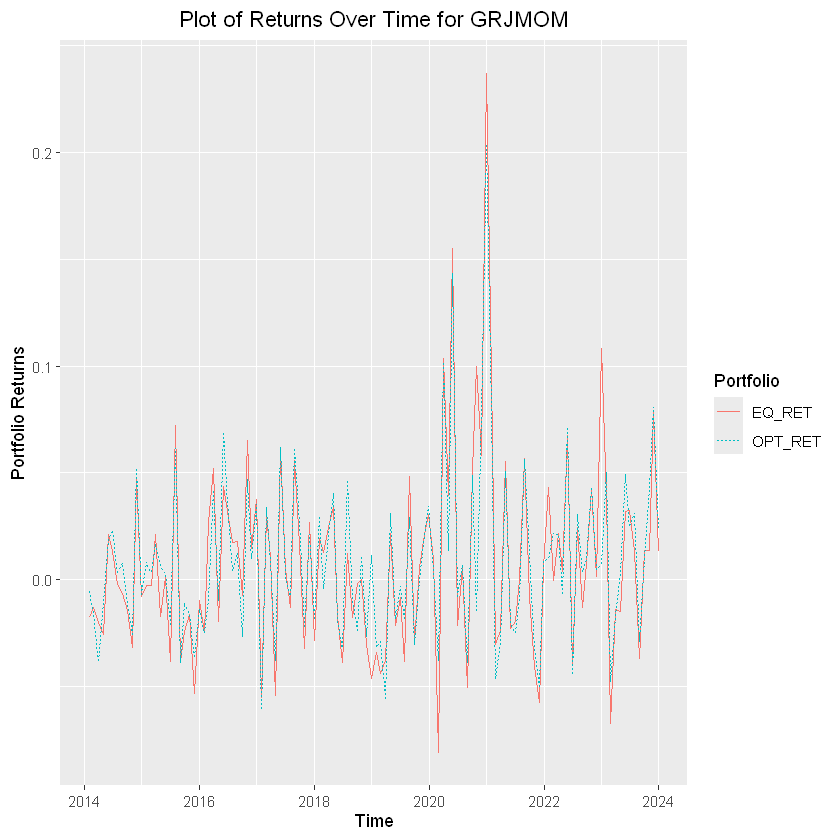

In [40]:
#Plot returns
Plot_Returns(test_grj_perf, "GRJMOM")

## WML *

Our third risk-adjusted factor we test is WML*.

In [41]:
#Test portfolio
wml_feat <- c("XRM", "MCAP", "BMKT", "WML_star")
test_wml_perf <- Ensemble_Performance(training_sample, testing_sample, wml_feat)

In [42]:
#Print summary statistics
Basic_Summary_Stat(test_wml_perf$OPT_RET, "WML* Optimal Weight")
Basic_Summary_Stat(test_wml_perf$EQ_RET, "WML* Equal Weight")

[1] "For WML* Optimal Weight the average annual return is 0.1291, the standard deviation is 0.1448 and the Sharpe Ratio is 0.8918. The skew is 1.0522 and the kurtosis is 3.4384"
[1] "For WML* Equal Weight the average annual return is 0.142, the standard deviation is 0.1634 and the Sharpe Ratio is 0.8687. The skew is 1.5607 and the kurtosis is 4.7313"


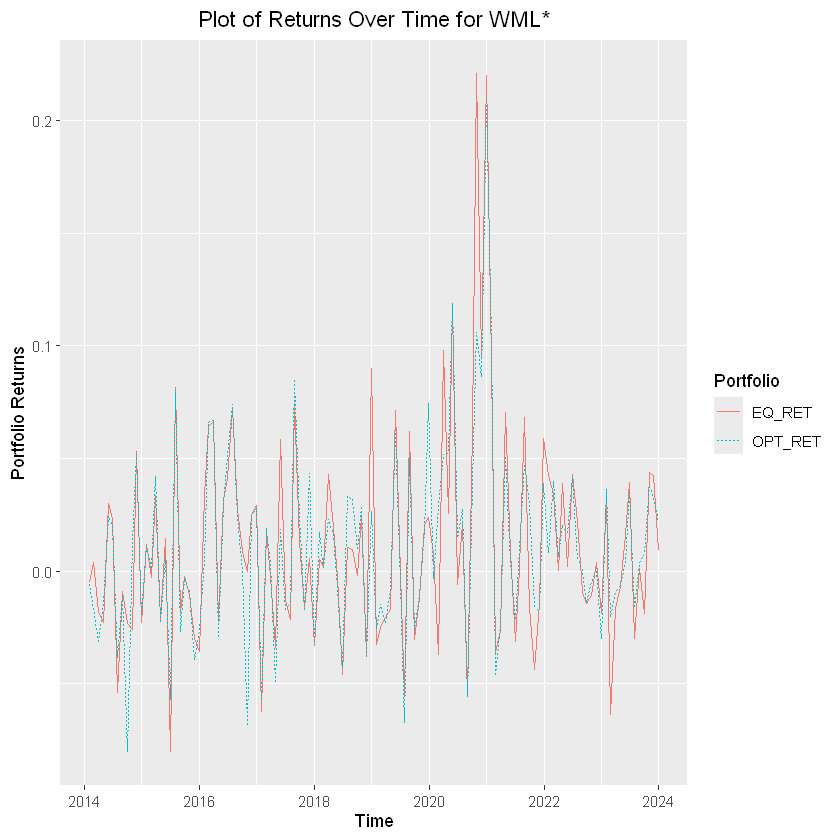

In [43]:
#Plot returns
Plot_Returns(test_wml_perf, "WML*")

## Combined Model

Finally, create a model using all of the momentum factors.

In [44]:
all_feat <- c("XRM", "MCAP", "BMKT", "RET11", "GRJMOM", "WML_star", "RV")
test_all_perf <- Ensemble_Performance(training_sample, testing_sample, all_feat)

In [45]:
Basic_Summary_Stat(test_all_perf$OPT_RET, "All Factors Optimal Weight")
Basic_Summary_Stat(test_all_perf$EQ_RET, "All Factors Equal Weight")

[1] "For All Factors Optimal Weight the average annual return is 0.1263, the standard deviation is 0.1554 and the Sharpe Ratio is 0.8132. The skew is 1.269 and the kurtosis is 2.8187"
[1] "For All Factors Equal Weight the average annual return is 0.1461, the standard deviation is 0.1739 and the Sharpe Ratio is 0.84. The skew is 2.0903 and the kurtosis is 8.0979"


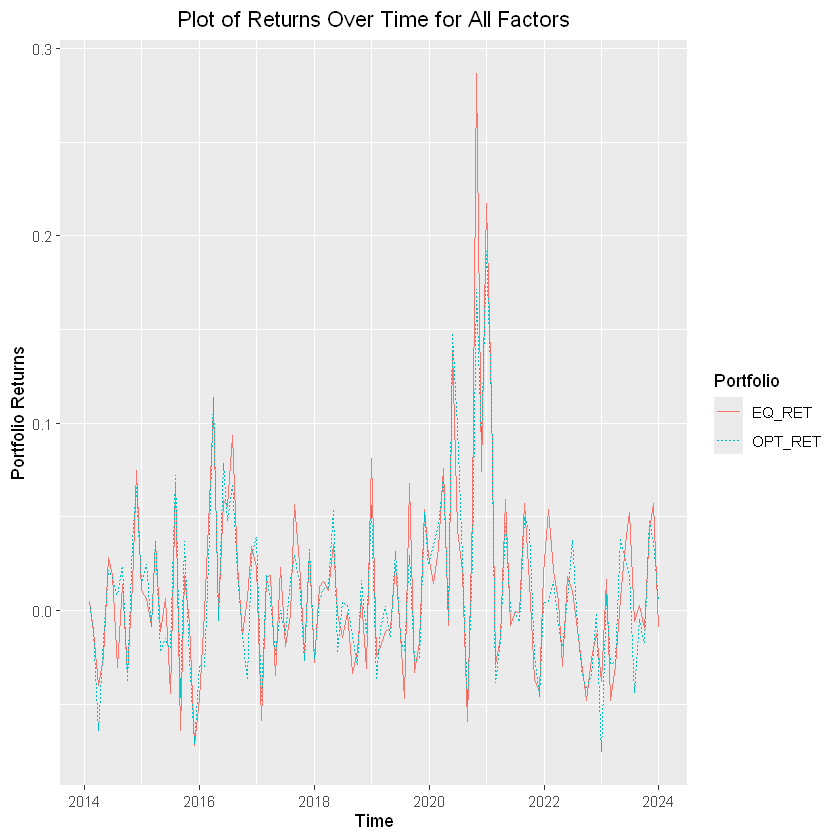

In [46]:
Plot_Returns(test_all_perf, "All Factors")

## Additional Graphs

Finally, to examine crash performance, portfolios all on the same graph.

In [47]:
#Combine datasets and rename
port_names <- c("DATE", "RET11", "RV", "GRJMOM", "WML*")

eq_ret <- left_join(test_bench_perf, test_rv_perf, by = c("DATE")) %>%
    left_join(test_grj_perf, by = c("DATE")) %>%
    left_join(test_wml_perf, by = c("DATE")) %>%
    filter(DATE >= "2020-01-01", DATE <= "2021-01-01") %>%
    select(-starts_with("OPT")) %>%
    setNames(port_names)

opt_ret <- left_join(test_bench_perf, test_rv_perf, by = c("DATE")) %>%
    left_join(test_grj_perf, by = c("DATE")) %>%
    left_join(test_wml_perf, by = c("DATE")) %>%
    filter(DATE >= "2020-01-01", DATE <= "2021-01-01") %>%
    select(-starts_with("EQ")) %>%
    setNames(port_names)

head(eq_ret, 3)

DATE,RET11,RV,GRJMOM,WML*
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-31,0.02593888,0.001575428,0.009611325,0.007652788
2020-02-29,-0.13263318,-0.080181356,-0.080701754,-0.036820874
2020-03-31,0.11776247,0.157538247,0.103347245,0.097845156


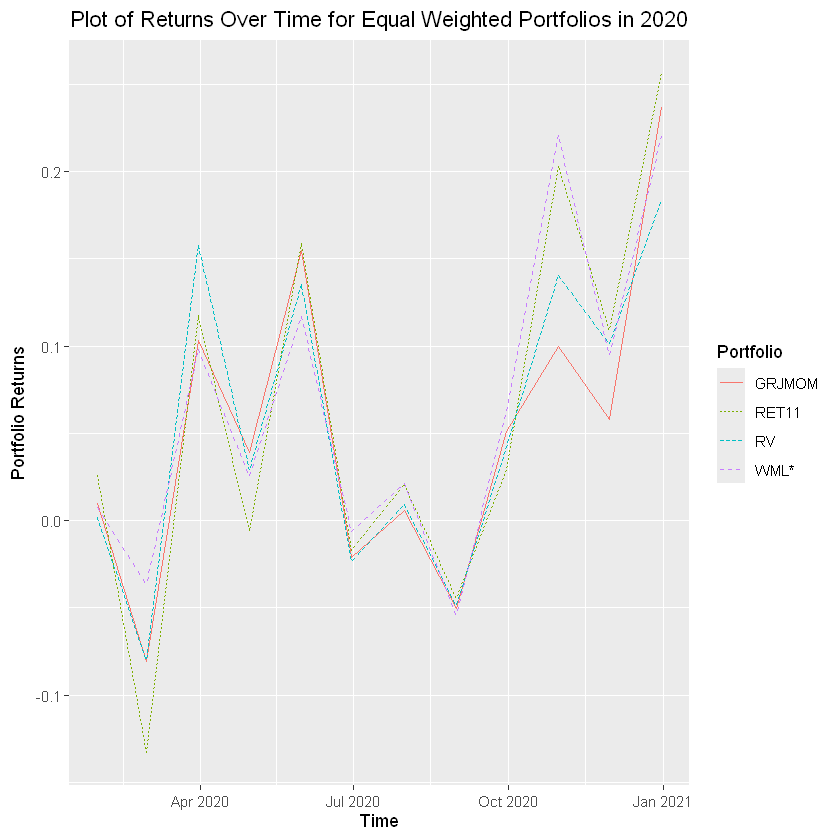

In [48]:
#Plot equal weighted returns
Plot_Returns(eq_ret, "Equal Weighted Portfolios in 2020")

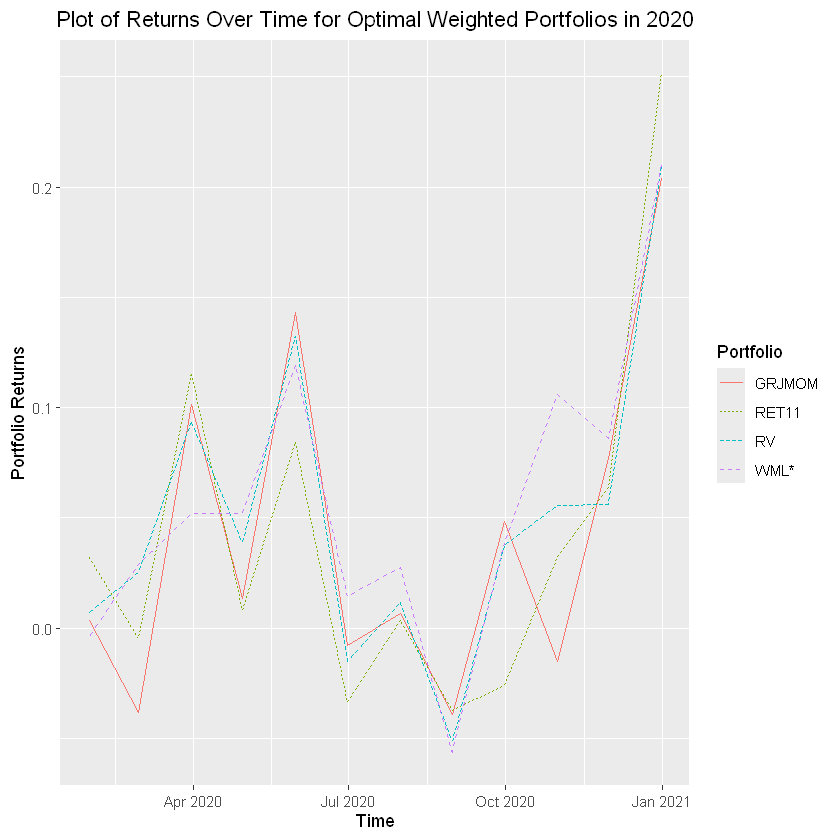

In [49]:
#Plot optimal weighted returns
Plot_Returns(opt_ret, "Optimal Weighted Portfolios in 2020")